In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from sklearn.linear_model import Ridge
sns.set()
%matplotlib inline

## 1. Business Understanding

### 3 questions relating to the data:

For the 3 questions, I decided to focus exclusively on US companies/start-ups, as I have a better feel for the US business
environment

1. Which markets are funded the most when looking at a typical company within that market?

2. What are the most important variables in predicting total funding, aside from the actual funding rounds (because these 
would arithmetically add up to total funding)?

3. For technology companies that were acquired, how much on average does the acquisition price
exceed total funding?


## 2. Data Understanding

The data used for this project originally comes from the Crunchbase website - a platform with business information about
private and public companies. I personally downloaded the data from Tableau public. The Excel file indicates that data was
extracted from Crunchbase on Dec 2, 2014. There are three relevant data tabs: *Companies*, *Investments*, *Acquisitions*
and *Rounds*.

**Companies** tab contains data on which companies were funded, when and for how much.

**Investments** tab contains data on the different investors investing in the companies.

**Acquisitions** tab contains data on the companies acquired and how much they were acquired for.

**Rounds** tab contains more detailed data on the different rounds of funding, e.g., seed, venture A,B,C etc and how much
the rounds were for.

## 3. Data Preparation (general)

In [2]:
'''Gather Data'''
companies=pd.read_csv('./Data/crunchbase_companies.csv', encoding = "ISO-8859-1")
acquisitions=pd.read_csv('./Data/crunchbase_acquisitions.csv', encoding = "ISO-8859-1")

In [3]:
#Take a glimpse at the data
print('Companies Shape: ', companies.shape)
companies.head()

Companies Shape:  (49438, 15)


,company_name,market,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,founded_month,founded_quarter,founded_year,first_funding_at,last_funding_at
0,#waywire,News,"1,750,000",acquired,USA,NY,New York City,New York,1,6/1/2012,2012-06,2012-Q2,2012.0,6/30/2012,6/30/2012
1,&TV Communications,Games,"4,000,000",operating,USA,CA,Los Angeles,Los Angeles,2,NaN,NaN,NaN,NaN,6/4/2010,9/23/2010
2,'Rock' Your Paper,Publishing,"40,000",operating,EST,NaN,Tallinn,Tallinn,1,10/26/2012,2012-10,2012-Q4,2012.0,8/9/2012,8/9/2012
3,(In)Touch Network,Electronics,"1,500,000",operating,GBR,NaN,London,London,1,4/1/2011,2011-04,2011-Q2,2011.0,4/1/2011,4/1/2011
4,-R- Ranch and Mine,Tourism,"60,000",operating,USA,TX,Dallas,Fort Worth,2,1/1/2014,2014-01,2014-Q1,2014.0,8/17/2014,9/26/2014


In [4]:
print('Acquisitions Shape: ', acquisitions.shape)
acquisitions.head()

Acquisitions Shape:  (13070, 17)


,company_name,company_market,company_country_code,company_state_code,company_region,company_city,acquirer_market,acquirer_country_code,acquirer_state_code,acquirer_region,acquirer_city,acquired_at,acquired_month,acquired_quarter,acquired_year,price_amount,price_currency_code
0,#waywire,News,USA,NY,New York City,New York,Curated Web,USA,NY,New York City,New York,10/17/2013,2013-10,2013-Q4,2013.0,NaN,USD
1,(fluff)Friends,NaN,NaN,NaN,NaN,NaN,Games,USA,CA,Los Angeles,Beverly Hills,9/16/2008,2008-09,2008-Q3,2008.0,NaN,USD
2,(RED),Nonprofits,USA,NY,New York City,New York,Finance,USA,TX,Dallas,Lewisville,5/8/2014,2014-05,2014-Q2,2014.0,"18,000,000",USD
3,.,NaN,NaN,NaN,NaN,NaN,NaN,USA,FL,Palm Beaches,West Palm Beach,1/1/2011,2011-01,2011-Q1,2011.0,NaN,USD
4,.CO,Registrars,USA,FL,Miami,Miami,Analytics,USA,VA,"Washington, D.C.",Sterling,3/20/2014,2014-03,2014-Q1,2014.0,"109,000,000",USD


In [5]:
#Clean column names: strip unnecessary spaces, if any
companies.columns=companies.columns.str.strip()
acquisitions.columns=acquisitions.columns.str.strip()

In [6]:
#Subset only US companies in both datasets. It looks like US was already the predominant country,
#based on the number of records
print(companies['country_code'].value_counts().head())
print(acquisitions['company_country_code'].value_counts().head())

companies_us = companies[companies['country_code']=='USA'].reset_index(drop=True)
acquisitions_us= acquisitions[acquisitions['company_country_code']=='USA'].reset_index(drop=True)

USA    28793
GBR     2642
CAN     1405
CHN     1239
DEU      968
Name: country_code, dtype: int64
USA    7177
GBR     646
CAN     348
DEU     206
FRA     138
Name: company_country_code, dtype: int64


**Question 1: Which markets are funded the most when looking at a typical company within that market?**


To answer this question, we will take median total funding by market. First, however, we need to consolidate the number
of markets, as there are too many. Next, we will adjust total funding for inflation based on the year when the funding occurred. We will only work with rows that have non-null total funding values. Imputing total funding is not practical, as it will reduce variability of our results.

## 3.1. Data Preparation (Question 1)

In [7]:
'''Assess data'''

#1.1 Let's take a look what kind and how many markets we have

print('Number of markets: ',len(companies_us['market'].value_counts()))

companies_us['market'].value_counts().head()

Number of markets:  692


 Software          2962
 Biotechnology     2716
 Mobile            1032
 Curated Web        941
 Health Care        915
Name: market, dtype: int64

In [8]:
#1.2 There are way too many markets, we need to consolidate them into fewer categories.
#    I went through each market and map it into 24 broad categories, as seen in this dataframe

markets=pd.read_csv('./Data/categories.csv')

In [9]:
markets.head() 

,market,market_category
0,News,News & Media & Publushing
1,Games,Technology
2,Tourism,Travel
3,Software,Technology
4,Health and Wellness,Health & Wellness


In [10]:
'''Clean data'''
#Remove leading and trailing spaces from the column names in the markets df
markets.columns=markets.columns.str.strip()
markets.columns

Index(['market', 'market_category'], dtype='object')

In [11]:
# 1.3 From a dataframe create a dictionary of market & corresponding market_category to use for look-up
keys=markets['market'].str.strip()
values=markets['market_category'].str.strip()
market_dict=dict(zip(keys, values))

dict(list(market_dict.items())[0:10])

{'News': 'News & Media & Publushing',
 'Games': 'Technology',
 'Tourism': 'Travel',
 'Software': 'Technology',
 'Health and Wellness': 'Health & Wellness',
 'Real Estate': 'Real Estate',
 'E-Commerce': 'Technology',
 'Search': 'Technology',
 'Curated Web': 'Technology',
 'Health Care Information Technology': 'Health & Wellness'}

In [12]:
#1.4 Create a market category column as a copy of the market column, strip all unnecessary spaces in market names
companies_us.loc[:,('market_category')]=companies_us.loc[:, ('market')]
companies_us.loc[:,('market_category')]=[str(x).strip() for x in companies_us.loc[:, ('market')]]

#Note: the reason I am using a .loc subsetting is to avoid chained assignments, which may lead to unpredictable
#results. Without using .loc, I would be getting a Python warning:' A value is trying to be set on a copy of 
#a slice from a DataFrame.'

In [13]:
#1.4 Look-up each market and obtain market_category using our market dictionary
companies_us.loc[:,('market_category')]=companies_us.market_category.replace(market_dict)

In [14]:
companies_us.market_category.head()

0    News & Media & Publushing
1                   Technology
2                       Travel
3                   Technology
4                   Technology
Name: market_category, dtype: object

In [15]:
#1.5 Ensure that numeric columns are either ints or floats
companies_us.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28793 entries, 0 to 28792
Data columns (total 16 columns):
company_name         28793 non-null object
market               27029 non-null object
funding_total_usd    28793 non-null object
status               28233 non-null object
country_code         28793 non-null object
state_code           28767 non-null object
region               28793 non-null object
city                 28730 non-null object
funding_rounds       28793 non-null int64
founded_at           23696 non-null object
founded_month        23635 non-null object
founded_quarter      23635 non-null object
founded_year         23635 non-null float64
first_funding_at     28793 non-null object
last_funding_at      28793 non-null object
market_category      28793 non-null object
dtypes: float64(1), int64(1), object(14)
memory usage: 3.5+ MB


In [16]:
# Total funding is an 'object', b/c it's a string with commas
print(companies_us['funding_total_usd'][0:5])

#This function will clean up the total_funding column
def clean_numeric(x):
    '''
    Input
    a string
    
    Output
    a float, stripped from extra spaces, without commas and dollar signs;
    dashes converted to NaNs
    '''
    x=x.strip()
    x=x.replace(',', '')
    x=x.replace('-', 'NaN')
    x=x.replace('$','')
    return float(x)  

0    1,750,000
1    4,000,000
2       60,000
3    7,000,000
4         -   
Name: funding_total_usd, dtype: object


In [17]:
#Clean-up total funding column
companies_us.loc[:,('funding_total_usd')]=companies_us.funding_total_usd.map(clean_numeric)

In [18]:
#Check our work
print(companies_us.funding_total_usd[0:5])

0    1750000.0
1    4000000.0
2      60000.0
3    7000000.0
4          NaN
Name: funding_total_usd, dtype: float64


In [19]:
companies_us.shape

(28793, 16)

In [20]:
#1.6 Check how many missing values we have in total funding
print('Total Missing: ',companies_us['funding_total_usd'].isna().sum())
print('Proportion Missing: ', companies_us['funding_total_usd'].isna().sum()/companies_us.shape[0])

#15% of rows have missing values, these would need to be removed later on.

Total Missing:  4276
Proportion Missing:  0.14850831799395686


In [21]:
#1.7 To appropriately adjust total funding for inflation, we need reliable funding date information. Let's check
#if there are any weird values, such as dates starting with double zeros
print([companies_us.index[companies_us['first_funding_at']==x] for x in companies_us.loc[:,('first_funding_at')] if x[:2]=='00'])
print([companies_us.index[companies_us['last_funding_at']==x] for x in companies_us.loc[:,('last_funding_at')] if x[:2]=='00'])

[Int64Index([21941], dtype='int64')]
[]


In [22]:
#None were found in the last funding date, and one found in the first funding date
companies_us.loc[21941,'first_funding_at']

'0011-11-14'

In [23]:
#1.8 Re-format the date properly
companies_us.loc[21941,'first_funding_at']='2011-11-14'

In [24]:
#To express total funding in terms of 2014 dollars (the year when the data was pulled), we'll need to adjust 
#for inflation based on the year of funding.

#The funding most likely occurred throughout multiple years, but would it hurt if for simplicity we assumed that
#it all occurred on the 'last_funding_at'? Let's see what the mean difference is between 'first_funding_at' and
#'last_funding_at'.

#1.9 Find mean difference between first and last funding dates

def yeardiff(string1, string2):
    '''Input:
    two date strings
    
    Output:
    difference between dates in number of years
    '''
    dt1=pd.DatetimeIndex(string1)
    dt2=pd.DatetimeIndex(string2)
    diff=((dt2-dt1).days)/365
    return diff

In [25]:
#1.9 Mean difference between first and last funding is only 1.07 years, which is not very significant,
#we are okay using the year of 'last_funding_at' to adjust for inflation

np.nanmean(yeardiff(list(companies_us.first_funding_at), list(companies_us.last_funding_at)))

1.0673651177583592

Minimum Year:  1960


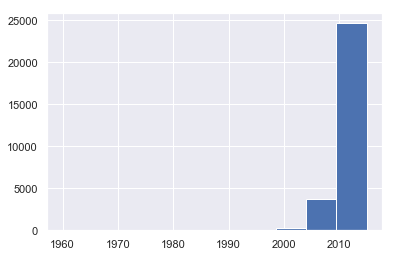

In [26]:
#1.10 Distribution of last funding dates (by year)
print('Minimum Year: ',min(pd.to_datetime(companies_us.last_funding_at)).year) #minimum year of last funding is 1960

companies_us.loc[:, ('first_funding_at')]=pd.DatetimeIndex(companies_us.loc[:, ('first_funding_at')]) #convert to date
companies_us.loc[:, ('last_funding_at')]=pd.DatetimeIndex(companies_us.loc[:, ('last_funding_at')]) #convert to date

companies_us['last_funding_at'].hist(); 

#majority of funding occurred after 2010, so the adjusted total funding for most companies would not be that much different
#from the original value.

In [27]:
#1.11 Download the inflation dataframe and create a dictionary out of it for lookup
inf=pd.read_csv('./Data/inflation_data.csv', encoding = "ISO-8859-1")

def create_dict(key_col, value_col):
    '''
    Input
    list of keys
    list of values
    
    Output
    dictionary
    '''
    
    my_keys=key_col.values
    my_values=value_col.values
    my_dict=dict(zip(my_keys, my_values))
    return my_dict

print(inf.head()) #although our minimum funding year is 1960, 1963 in the inflation data should be close enough

   year  amount  inflation_factor
0  1963  100.00              7.74
1  1964  101.31              7.64
2  1965  102.94              7.52
3  1966  105.88              7.31
4  1967  109.15              7.09


In [28]:
inflation_dict=create_dict(inf.year, inf.inflation_factor)
dict(list(inflation_dict.items())[0:10]) #preview dictionary

{1963: 7.74,
 1964: 7.64,
 1965: 7.52,
 1966: 7.31,
 1967: 7.09,
 1968: 6.8,
 1969: 6.45,
 1970: 6.1,
 1971: 5.85,
 1972: 5.66}

In [29]:
#Manually add years 1960 through 1962, assuming they have the same inflation factor as 1963
add_years=np.arange(1960, 1963)
for year in add_years:
    inflation_dict[year]=7.74

In [30]:
#1.12 Calculate inflation adjusted total_funding (for rows that have funding values)

#Subset only rows that have funding
companies_us=companies_us[companies_us['funding_total_usd'].notna()].reset_index(drop=True)
companies_us.shape

(24517, 16)

In [31]:
#1.13 Function that takes in funding and date columns + inflation dictionary and returns a list of converted values
def inflation_converter(funding_col, date_col, infl_dict, years_only=False):
    '''
    Input:
    dataframe column containing dollar values of funding
    dataframe column containing dates of funding
    dictionary containing years as keys and inflation factors as values
    years_only flag indicating whether the date column contains only 4 digit years or full dates
    
    Output:
    list of funding values adjusted for inflation
    '''
        
    dates=date_col.values
    if years_only==True:
        years=[int(x) for x in dates]
    else:
        years=pd.DatetimeIndex(dates).year
        years=[int(x) for x in years]

    funding=funding_col.values
    funding=[int(x) for x in funding]
    
    adjusted_funding=[]
    
    for year, dollars in zip(years, funding):
        adjusted_funding.append(round((infl_dict[year] * dollars),0))
        
    return adjusted_funding

In [32]:
#Run the function to create adjusted funding column
companies_us.loc[:,('adjusted_funding')]=inflation_converter(companies_us['funding_total_usd'], companies_us['last_funding_at'], inflation_dict, years_only=False)

In [33]:
companies_us.head() #it's the last column

,company_name,market,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,founded_month,founded_quarter,founded_year,first_funding_at,last_funding_at,market_category,adjusted_funding
0,#waywire,News,1750000.0,acquired,USA,NY,New York City,New York,1,6/1/2012,2012-06,2012-Q2,2012.0,2012-06-30,2012-06-30,News & Media & Publushing,1802500.0
1,&TV Communications,Games,4000000.0,operating,USA,CA,Los Angeles,Los Angeles,2,NaN,NaN,NaN,NaN,2010-06-04,2010-09-23,Technology,4360000.0
2,-R- Ranch and Mine,Tourism,60000.0,operating,USA,TX,Dallas,Fort Worth,2,1/1/2014,2014-01,2014-Q1,2014.0,2014-08-17,2014-09-26,Travel,60000.0
3,.Club Domains,Software,7000000.0,NaN,USA,FL,Ft. Lauderdale,Oakland Park,1,10/10/2011,2011-10,2011-Q4,2011.0,2013-05-31,2013-05-31,Technology,7140000.0
4,1-800-DOCTORS,Health and Wellness,1750000.0,operating,USA,NJ,Newark,Iselin,1,1/1/1984,1984-01,1984-Q1,1984.0,2011-03-02,2011-03-02,Health & Wellness,1837500.0


In [34]:
#1.14 Since we'll be using market category to answer our 1st question, make sure we don't have any nan's 
print('Number of Nans: ',(companies_us['market_category']=='nan').sum())

Number of Nans:  1131


In [35]:
#1.15 There are some nan's, let's set them to 'Other'

#Obtain indices of nan's
nans=[i for i, x in enumerate(companies_us.loc[:,('market_category')]) if x=='nan'] #indices of nans
companies_us.loc[nans, 'market_category']='Other'

In [36]:
#1.16 Create a dataframe of median funding by market category
market_summary=companies_us.groupby('market_category', as_index=False)['adjusted_funding'].median()
market_summary.columns=['market_category','median_funding']
market_summary=market_summary.sort_values('median_funding', ascending=True).reset_index(drop=True)

## 4.1. Data Evaluation (Question 1)

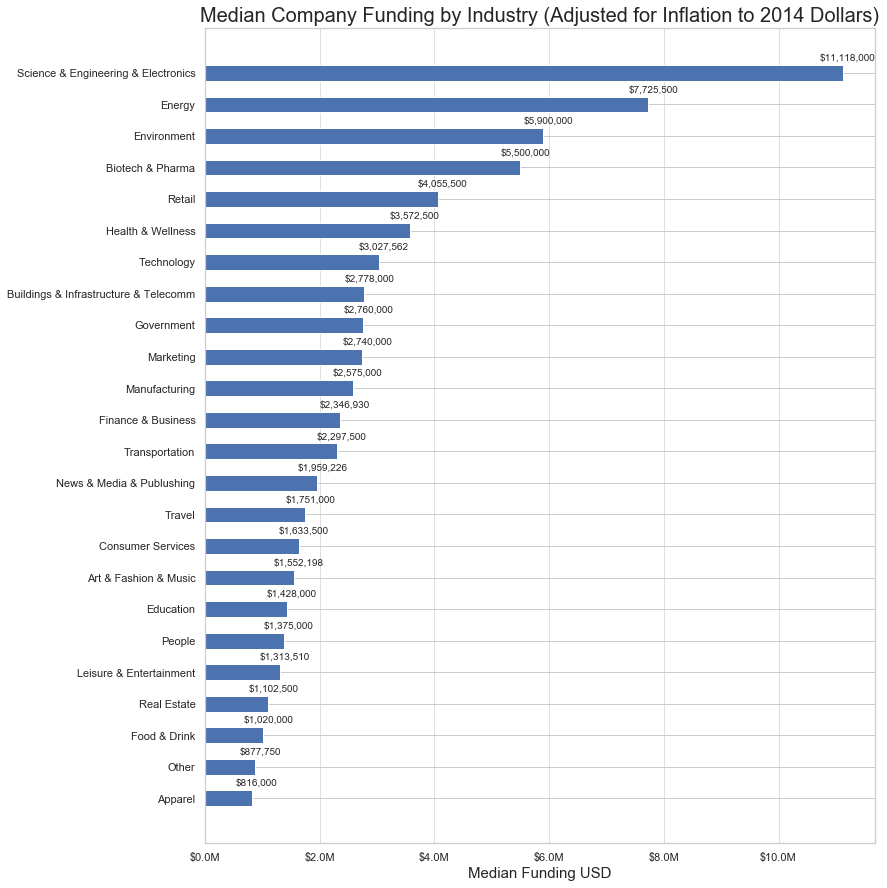

In [72]:
'''Analyze & Visualize data'''

#1.17 Finally, it's time to create a bar chart showing median funding adjusted for inflation by market category

fig, ax = plt.subplots(figsize=(12, 15))

sns.set_style("whitegrid")

_ = plt.barh(market_summary['market_category'], market_summary['median_funding'], align='center', 
             height=0.5)

_ = plt.grid(which='major', axis='x', color='grey', alpha = 0.25)

_ = plt.title('Median Company Funding by Industry (Adjusted for Inflation to 2014 Dollars)', fontsize = 20)

_ = plt.xlabel('Median Funding USD', fontsize=15)

def millions(x, pos):
    'The two args are the value and tick position'
    return '$%1.1fM' % (x*1e-6)

formatter = FuncFormatter(millions)

ax.xaxis.set_major_formatter(formatter)

for x,y in zip (market_summary.median_funding, market_summary.market_category):
    
    label = '${:,.0f}'.format(x)
    
    plt.annotate(label,  (x,y), textcoords="offset points", xytext = (5,15), ha='center', va='center')

plt.show()

In [38]:
#1.18 Create a supporting dataframe to provide context to the median funding bar chart, if needed
(companies_us.groupby('market_category')['adjusted_funding']
 .agg(['count','min', 'max', 'mean', 'median', 'sum'])
 .sort_values('sum', ascending=False)
 .style.format('${0:,.0f}', subset=['min', 'max', 'mean', 'median', 'sum'])
 .bar(color='lightgreen', subset=['min'])
 .bar(color='lightblue', subset=['max'])
 .bar(color='pink', subset=['mean'])
 .bar(color='#FFA07A', subset=['median'])
 .bar(color='orange', subset=['sum']))

,count,min,max,mean,median,sum
market_category,,,,,,
Technology,10224,$51,"$5,814,000,000","$15,930,410","$3,027,562","$162,872,514,933"
Biotech & Pharma,2697,"$1,020","$2,448,000,000","$22,313,878","$5,500,000","$60,180,528,683"
Health & Wellness,2038,$100,"$2,652,000,000","$24,437,528","$3,572,500","$49,803,682,976"
Buildings & Infrastructure & Telecomm,944,"$1,030","$30,079,503,000","$44,384,398","$2,778,000","$41,898,871,658"
Energy,788,$300,"$1,498,515,340","$49,159,058","$7,725,500","$38,737,337,373"
Finance & Business,1872,$100,"$3,500,000,000","$16,775,202","$2,346,930","$31,403,178,001"
Other,1180,$144,"$5,162,513,431","$12,842,443","$877,750","$15,154,082,864"
Science & Engineering & Electronics,597,$102,"$518,799,995","$25,230,942","$11,118,000","$15,062,872,151"
Marketing,943,$118,"$1,193,850,000","$15,346,242","$2,740,000","$14,471,506,345"


In [39]:
#Science & Engineering & Electronics funding by Company, top 5
(companies_us[companies_us['market_category']=='Science & Engineering & Electronics'].groupby('company_name', as_index=False)['adjusted_funding']
 .agg('sum')
 .sort_values('adjusted_funding', ascending=False)
 .reset_index(drop=True)
 .head(n=5)
 .style.format('${0:,.0f}', subset=['adjusted_funding']))

,company_name,adjusted_funding
0,Jawbone,"$518,799,995"
1,A123 Systems,"$517,945,800"
2,Sonos,"$330,429,000"
3,Alien Technology,"$247,377,366"
4,Soft Machines,"$220,887,796"


In [40]:
#Technology funding by Company, top 5
(companies_us[companies_us['market_category']=='Technology'].groupby('company_name', as_index=False)['adjusted_funding']
 .agg('sum')
 .sort_values('adjusted_funding', ascending=False)
 .reset_index(drop=True)
 .head(n=5)
 .style.format('${0:,.0f}', subset=['adjusted_funding']))

,company_name,adjusted_funding
0,Clearwire,"$5,814,000,000"
1,Zebra Technologies,"$2,000,000,000"
2,Twitter,"$1,218,174,837"
3,Cloudera,"$1,201,000,000"
4,Xerox,"$1,133,000,000"


**Question 2: What are the most important variables in predicting total funding, aside from the actual 
funding rounds (because these would arithmetically add up to total funding)?**

To answer this question, we will use data in the 'Companies' data frame. Recall that we also we have access to the 'Rounds'
data, which shows funding amounts for each round, such as seed, venture, equity crowdfunding etc. However, for our purposes
this data is not useful, as it would arithmetically add up to total funding.

We will use Ridge regression to predict funding (adjusted for inflation) and would leverage the following columns:

1. Status (as of 2014) - acquired, operating, closed. *categorical*
2. Company State_code *categorical*
3. Company Region *categorical*
4. Company City *categorical*
5. Funding Rounds *numeric* - shows total number of funding rounds
6. Founded_at & founded_year *numeric* - founded_year to be used if a lot of missing values in founded_at
7. First Funding At *numeric*
8. Last Funding At *numeric*
9. Market Category *categorical*

We would also drop the following columns, as they do not contribute to our analysis:
1. Company Name - is unique to each company, does not have an effect on funding
2. Market - this column is too granular, has too much variation, so we would just use our compiled market_categories
3. Funding_total_usd - will correlate to adjusted_funding b/c of the inflation factor
4. Country Code - no variation, all USA
5. Founded_month, founded_quarter - not necessary if we keep founded_at

## 3.2. Data Preparation (Question 2)

In [41]:
#2.1 Drop the columns not used
companies_funding=companies_us.drop(['company_name', 'market', 'funding_total_usd', 'country_code', 'founded_month', 'founded_quarter'], axis=1)

In [42]:
companies_funding.head()

,status,state_code,region,city,funding_rounds,founded_at,founded_year,first_funding_at,last_funding_at,market_category,adjusted_funding
0,acquired,NY,New York City,New York,1,6/1/2012,2012.0,2012-06-30,2012-06-30,News & Media & Publushing,1802500.0
1,operating,CA,Los Angeles,Los Angeles,2,NaN,NaN,2010-06-04,2010-09-23,Technology,4360000.0
2,operating,TX,Dallas,Fort Worth,2,1/1/2014,2014.0,2014-08-17,2014-09-26,Travel,60000.0
3,NaN,FL,Ft. Lauderdale,Oakland Park,1,10/10/2011,2011.0,2013-05-31,2013-05-31,Technology,7140000.0
4,operating,NJ,Newark,Iselin,1,1/1/1984,1984.0,2011-03-02,2011-03-02,Health & Wellness,1837500.0


In [43]:
#2.2 Correct any weird looking dates
companies_funding.index[companies_funding.loc[:, ('founded_at')]=='1636-09-08']

Int64Index([9243], dtype='int64')

In [44]:
companies_funding.loc[9243, 'founded_at']='1936-09-08' #1636 probably meant to be 1936

In [45]:
#2.3 Format founded date as date and look at missing values

companies_funding['founded_at']=pd.DatetimeIndex(companies_funding.loc[:, ('founded_at')]) 

#This initially produced an error, so I added 2 cells above to correct the weird value (see 2.2)

In [46]:
'''Assess data'''

#2.4 Let's look at how many missing values each column has

def missing_quant(col):
    '''INPUT: column in a pandas dataframe
    
       OUTPUT: 
       1. Count of missing values
       2. Proportion of missing values in relation to all values
       
       Output is a tuple of the form (1,2)
    '''    
    
    na=col.isna().sum()
    not_na = col.notna().sum()
    prop=round(na/(na+not_na)*100,2)
    return (na, str(prop)+'%')

In [47]:
#Founded date & year are missing 18% of values, no other columns have that many missing
#No numeric columns have missing values
#Looks like 60 missing values in founded_year have a corresponding value in founded_at
#Which means we can use them to obtain the year

companies_funding.apply(lambda col: missing_quant(col))

status                (470, 1.92%)
state_code             (14, 0.06%)
region                   (0, 0.0%)
city                   (37, 0.15%)
funding_rounds           (0, 0.0%)
founded_at          (4436, 18.09%)
founded_year        (4496, 18.34%)
first_funding_at         (0, 0.0%)
last_funding_at          (0, 0.0%)
market_category          (0, 0.0%)
adjusted_funding         (0, 0.0%)
dtype: object

In [48]:
'''Clean data'''

#2.5 sklearn model will not fit on datetime columns, so we'll need to split first_funding at and last_funding_at
#into day, month and year components

def split_date(col):
    '''
    Input
    dataframe column containing dates
    
    Output
    parsed days, months and years from the date column
    '''
    my_dates = pd.DatetimeIndex(col.values)
    days=[x.day for x in my_dates]
    months=[x.month for x in my_dates]
    years=[x.year for x in my_dates]
    
    return days, months, years

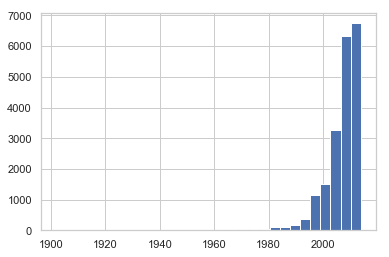

In [71]:
'''Analyze data'''
#Let's look at distribution of founding years
plt.hist(companies_us['founded_year'], bins=30)
plt.show();

In [50]:
#2.6 All of our missing values are concentrated within categorical variables: status, state_code, city.
#Status, city and state code are missing just a handful of values (<2%), so it seems appropriate to impute those based
#on mode. Especially for 'status', since most companies in the data are 'operating' (not 'closed' or 'acquired')

#Majority of founded years can be imputed b/c the bulk of the companies were founded after year 2000, so we shouldn't
#be that far off.

def clean_data(df):
    '''
    INPUT
    df - pandas dataframe
    
    OUTPUT
    Clean dataframe with the following characteristics:
    1. Missing values imputed for 'status', 'state_code', 'city' using mode
    
    2. Obtain founded_year for 60 values where founded_at is populated, for the rest -
    impute missing based on mode
    
    3. Founded_at will no longer be used, as we're using founded_year instead
    
    4. Split first_funding_at and last_funding_at into day, month, year columns
    
    5. Dummy variables created for categorical variables
    
    6. Numeric variables stay as is, since they don't have
    anything missing at this point
    '''
    
    #Missing values imputed for 3 columns using mode (1st value from 'value_counts')
    my_cat_cols=['status', 'state_code', 'city']

    df=df.apply(lambda col: col.fillna(col.value_counts().index[0]) if col.name in my_cat_cols else col)
        
    #Find the indices of 60 values in founded_year that are populated in founded_at
    #Grab the year of those values
    missing_founded_at=companies_us[companies_funding.loc[:,('founded_at')].isnull()].index.tolist()
    missing_founded_yr=companies_us[companies_funding.loc[:,('founded_year')].isnull()].index.tolist()
    
    for ind in missing_founded_yr:
        if ind not in missing_founded_at:
            df.loc[ind, ('founded_year')]=df.loc[ind, ('founded_at')].year
            
    #Impute missing values for founded_year
    df=df.apply(lambda col: col.fillna(col.value_counts().index[0]) if col.name=='founded_year' else col)
    
    #Split first_funding_at and last_funding_at into day, month, year columns
    df['first_funding_day']=split_date(companies_funding['first_funding_at'])[0]
    df['first_funding_month']=split_date(companies_funding['first_funding_at'])[1]
    df['first_funding_year']=split_date(companies_funding['first_funding_at'])[2]
    
    df['last_funding_day']=split_date(companies_funding['last_funding_at'])[0]
    df['last_funding_month']=split_date(companies_funding['last_funding_at'])[1]
    df['last_funding_year']=split_date(companies_funding['last_funding_at'])[2]
    
    #Drop unneeded columns
    df=df.drop(['founded_at', 'first_funding_at', 'last_funding_at'], axis=1)
    
    #Remove Categorical variables from df, create dummies for them in a separate df
    #Concatenate the original df (with numerical variables only) & dummied df
    cat_vars = df.select_dtypes(include=['object']).copy().columns
    for var in  cat_vars:
        # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    
    return df

In [51]:
#2.7 Clean the data and look at the dimensions of a new df
clean_funding=clean_data(companies_funding)

In [52]:
clean_funding.shape 
#Even with a lot of categorical variables, number of columns does not exceed number of rows, which is good

(24517, 2287)

## 4.2. Modeling (Question 2)

In [53]:
'''Model'''

#2.8 Write a function that runs Ridge Regression on independent variables to predict adjusted_funding

def fit_ridge_mod(df, response_col, test_size=.3, rand_state=42, alpha=0.4):
    
    '''
    INPUT:
    df - a dataframe holding all the variables of interest
    response_col - a string holding the name of the column 
    test_size - a float between [0,1] about what proportion of data should be in the test dataset
    rand_state - an int that is provided as the random state for splitting the data into training and test
    alpha - a hyperparameter value for ridge regression between [0,1]
    
    OUTPUT:
    test_score - float - r2 score on the test data
    train_score - float - r2 score on the train data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    
    The function will: 
    1. Split data into an X matrix and a response vector y
    2. Create training and test sets of data
    3. Instantiate a Ridge model with normalized data
    4. Fit model to the training data
    5. Predict the response for the training data and the test data
    11. Obtain an rsquared value for both the training and test data
    '''

    #Split into explanatory and response variables
    X = df.drop(response_col, axis=1)
    y = df[response_col]

    #Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=rand_state)

    rg_model = Ridge(alpha=alpha, normalize=True) # Instantiate
    rg_model.fit(X_train, y_train) #Fit

    #Predict using the model
    y_test_preds = rg_model.predict(X_test)
    y_train_preds = rg_model.predict(X_train)

    #Score using your model
    test_score = r2_score(y_test, y_test_preds)
    train_score = r2_score(y_train, y_train_preds)

    return test_score, train_score, rg_model, X_train, X_test, y_train, y_test


In [54]:
#Run the function on our data
test_score, train_score, rg_model, X_train, X_test, y_train, y_test = fit_ridge_mod(clean_funding, 'adjusted_funding')

In [55]:
print('R-squared test score: ', round(test_score,4))

R-squared test score:  0.0113


In [56]:
print('R-squared train score: ', round(train_score,4))

R-squared train score:  0.0228


## 5.2. Evaluation (Question 2)

Only 2% of variation in adjusted funding on the train data is explained by our model and only 1% on the test data. 
It goes without saying that our model is not very good and also has some over-fitting. The variables that we used are not strong predictors of funding, but nevertheless let's take a look at which variables were the most impactful.

In [57]:
#Function to format numbers with a thousands separator
#We'll need it to format coefficients & for question 3
def format_nums(number_col, currency=False, decimals=0):
    '''
    Input: number column in a dataframe
    Output: number list formatted with a thousands separator, can be formatted as currency
    '''
    numbers=number_col.values
    format_string='{0:,.'+str(decimals)+'f}'
    currency_string='$'+format_string
    if currency:
        new=[currency_string.format(x) for x in numbers]
    else:
        new=[format_string.format(x) for x in numbers]
    return new

In [58]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    lm_model - linear model
    
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = coefficients
    coefs_df['abs_coefs'] = np.abs(coefficients)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False).reset_index(drop=True)
    coefs_df=coefs_df.apply(lambda col: format_nums(col) if col.name in ['coefs', 'abs_coefs'] else col)
    return coefs_df

#Use the function
coef_df = coef_weights(rg_model.coef_, X_train)

#A quick look at the top results
coef_df[['est_int', 'coefs']].head(20)

#City of the Company appears to be the most impactful predictor of adjusted funding. Interestingly enough, San Francisco
#is not in the top 20

#Coefficients are very large

,est_int,coefs
0,city_Sussex,"1,306,605,163"
1,city_Normal,"705,068,273"
2,city_Lincolnshire,"698,434,098"
3,city_Dania,"416,195,110"
4,city_Ankeny,"401,849,646"
5,city_Paterson,"174,972,901"
6,city_Woodridge,"167,205,929"
7,city_Texas,"153,531,305"
8,city_Stamford,"151,095,006"
9,city_Frankfort,"136,425,035"


**Question 3: For technology companies that were acquired, how much on average does the acquisition price exceed total funding?**

We will use the acquisition price data adjusted for inflation and join it to the companies data based on company name.
For Technology companies having both the funding and the acquisition information, we will obtain an array of "multiples" (acquisition cost divided by total funding). We will then use bootstrapping to generate a sampling distribution for the mean of "multiples". From the distribution, we will obtain a 95% confidence interval for the true multiple of acquisition cost over total funding for Technology companies.

## 3.3. Data Preparation (Question 3)

In [59]:
'''Assess data'''
#3.1 First, we need to clean-up acquisitions data: 
#1) drop rows that have blank acquisition price 
#2) impute acquisition year where necessary 
#3) adjust acquisition price for inflation 
#4) only retain necessary columns


print('Shape of acquisitions_us: ', acquisitions_us.shape)
print('Data with non-null acquisition price: ', acquisitions_us[acquisitions_us['price_amount'].notnull()].shape)
print('Data Type of acqisition price: ', type(acquisitions_us['price_amount'][1]))
print('Rows with null acquired_year column: ', acquisitions_us['acquired_year'].isnull().sum())
acquisitions_us.head(n=10)


#Looks like acquisition price data is pretty sparse, I wonder how much data we'll have for Technology companies
#Also price is formatted as a string, which we need to change

#Because in the end we want to obtain the truest 95% confidence interval for the ratio of acquisition price over total
#funding ("multiple"), it does not make sense to impute the missing values for the acquisition price, as that might
#dilute our results.

Shape of acquisitions_us:  (7177, 17)
Data with non-null acquisition price:  (2226, 17)
Data Type of acqisition price:  <class 'str'>
Rows with null acquired_year column:  1


,company_name,company_market,company_country_code,company_state_code,company_region,company_city,acquirer_market,acquirer_country_code,acquirer_state_code,acquirer_region,acquirer_city,acquired_at,acquired_month,acquired_quarter,acquired_year,price_amount,price_currency_code
0,#waywire,News,USA,NY,New York City,New York,Curated Web,USA,NY,New York City,New York,10/17/2013,2013-10,2013-Q4,2013.0,NaN,USD
1,(RED),Nonprofits,USA,NY,New York City,New York,Finance,USA,TX,Dallas,Lewisville,5/8/2014,2014-05,2014-Q2,2014.0,"18,000,000",USD
2,.CO,Registrars,USA,FL,Miami,Miami,Analytics,USA,VA,"Washington, D.C.",Sterling,3/20/2014,2014-03,2014-Q1,2014.0,"109,000,000",USD
3,1-800 Contacts,Retail,USA,UT,Salt Lake City,Draper,Business Development,USA,MA,Boston,Boston,1/7/2014,2014-01,2014-Q1,2014.0,NaN,USD
4,1000memories,Curated Web,USA,CA,SF Bay Area,San Francisco,Internet,USA,UT,Salt Lake City,Provo,10/3/2012,2012-10,2012-Q4,2012.0,NaN,USD
5,100Plus,Analytics,USA,CA,SF Bay Area,San Francisco,Health and Wellness,USA,CA,SF Bay Area,San Francisco,2/27/2013,2013-02,2013-Q1,2013.0,NaN,USD
6,10best,Curated Web,USA,SC,Greenville - Spartanburg,Greenville,Career Planning,USA,CA,SF Bay Area,San Francisco,1/25/2011,2011-01,2011-Q1,2011.0,NaN,USD
7,10East,Web Hosting,USA,FL,Jacksonville,Jacksonville,Enterprise Software,NaN,NaN,NaN,NaN,4/14/2009,2009-04,2009-Q2,2009.0,NaN,USD
8,12Society,E-Commerce,USA,CA,Los Angeles,West Hollywood,E-Commerce,USA,CA,Los Angeles,West Hollywood,7/3/2013,2013-07,2013-Q3,2013.0,NaN,USD
9,170 Systems,Software,USA,MA,Boston,Bedford,Software,USA,CA,Anaheim,Irvine,9/8/2009,2009-09,2009-Q3,2009.0,"43,000,000",USD


In [60]:
#3.2 Since there is only one row with a missing acquired year, let's see if we can populate it from the acquired_at
#column
null_ind=acquisitions_us[acquisitions_us['acquired_year'].isnull()].index[0]
print(acquisitions_us.loc[null_ind, ('acquired_at')]) #This looks like date 2014-09-30, let's populate year 2014 in acquired year
acquisitions_us.loc[null_ind, ('acquired_year')]='2014'

0030-09-14


In [61]:
'''Clean data'''

#3.3 Write a function to perform other cleaning on the acquisitions data, including inflation adjustment

def clean_acquisitions(df, inflation_dict):
    '''INPUT
    acquisitions dataframe
    
    OUTPUT
    acquisitions dataframe with company name, original price column,
    acquisitions price adjusted for inflation,
    acquisition year
    '''
    
    #Subset only rows in the dataframe that have non-null values for acquisition price
    df=df[df['price_amount'].notnull()]
    
    #Convert 'price amount' column to a number (it is currently formatted as a string)
    df.loc[:,('price_amount')]=df.price_amount.map(clean_numeric)
    
    #Use acquired year and inflation dictionary to look up inflation factor and adjust acquisition price
    df.loc[:, ('adjusted_price')]=df.loc[:, ('price_amount')]
    df.loc[:, ('adjusted_price')]=inflation_converter(df.loc[:, ('price_amount')], df.loc[:, ('acquired_year')], inflation_dict, years_only=True)
    
    #Format dollar value columns as currency
    df=df.apply(lambda col: format_nums(col, currency=True) if col.name in ['adjusted_price', 'price_amount'] else col)
    
    #Only retain needed columns
    df_new=df[['company_name', 'acquired_year', 'price_amount','adjusted_price',]]
    
    return df_new

In [62]:
acquisitions_clean=clean_acquisitions(acquisitions_us, inflation_dict)
acquisitions_clean.head(n=10)

C:\Users\Dina.Stretiner\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:630: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value
C:\Users\Dina.Stretiner\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Dina.Stretiner\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be

,company_name,acquired_year,price_amount,adjusted_price
1,(RED),2014,"$18,000,000","$18,000,000"
2,.CO,2014,"$109,000,000","$109,000,000"
9,170 Systems,2009,"$43,000,000","$47,300,000"
12,21st Century Insurance,2007,"$749,000,000","$853,860,000"
13,24/7 Real Media,2008,"$649,000,000","$713,900,000"
14,2nd Story Software- Inc.,2012,"$287,500,000","$296,125,000"
15,2Wire,2010,"$475,000,000","$517,750,000"
21,3Com,2009,"$2,700,000,000","$2,970,000,000"
24,3E Company,2010,"$110,000,000","$119,900,000"
27,3PAR,2010,"$2,350,000,000","$2,561,500,000"


In [63]:
#3.5 Now it's time to merge two datasets based on company name. Final data would have both total funding and
# acquisition price
companies_merged=companies_us.merge(acquisitions_clean, how='inner', on='company_name')
companies_merged=companies_merged[['company_name', 'market_category', 'founded_year', 'last_funding_at', 'acquired_year', 'funding_total_usd', 'adjusted_funding', 'price_amount', 'adjusted_price']]

#Format funding columns as dollars
companies_merged=companies_merged.apply(lambda col: format_nums(col, currency=True) if col.name in ['funding_total_usd', 'adjusted_funding'] else col)

In [64]:
#3.6 How many technology companies do we have in our data to compare adjusted_funding and adjusted_price?
print(companies_merged['market_category'].value_counts())

tech_companies=companies_merged[companies_merged['market_category']=='Technology'].reset_index(drop=True)

#423 companies, not a bad sample size

Technology                               423
Biotech & Pharma                          90
Finance & Business                        62
Health & Wellness                         54
Marketing                                 50
Buildings & Infrastructure & Telecomm     40
Science & Engineering & Electronics       37
Art & Fashion & Music                     19
Energy                                    18
News & Media & Publushing                 16
Manufacturing                              8
Travel                                     8
Consumer Services                          8
Education                                  6
Other                                      6
Transportation                             5
Leisure & Entertainment                    4
Real Estate                                3
Retail                                     2
Food & Drink                               1
People                                     1
Name: market_category, dtype: int64


In [65]:
tech_companies.head(n=10)

,company_name,market_category,founded_year,last_funding_at,acquired_year,funding_total_usd,adjusted_funding,price_amount,adjusted_price
0,170 Systems,Technology,1990.0,2002-04-16,2009,"$14,000,000","$18,480,000","$43,000,000","$47,300,000"
1,2nd Story Software- Inc.,Technology,1998.0,2005-03-30,2012,"$85,000,000","$102,850,000","$287,500,000","$296,125,000"
2,41st Parameter,Technology,2004.0,2012-04-11,2013,"$38,064,570","$39,206,507","$324,000,000","$330,480,000"
3,5min Media,Technology,2007.0,2009-07-23,2010,"$12,800,000","$14,080,000","$65,000,000","$70,850,000"
4,Aardvark,Technology,2007.0,2008-10-01,2010,"$6,000,000","$6,600,000","$50,000,000","$54,500,000"
5,Accertify,Technology,2007.0,2010-05-04,2010,"$7,131,124","$7,772,925","$150,000,000","$163,500,000"
6,Accuvant,Technology,2002.0,2014-10-17,2014,"$8,198,838","$8,198,838","$225,000,000","$225,000,000"
7,Acompli,Technology,2013.0,2013-06-04,2014,"$7,300,000","$7,446,000","$200,000,000","$200,000,000"
8,Acopia Networks,Technology,2002.0,2006-06-19,2007,"$20,000,000","$23,400,000","$210,000,000","$239,400,000"
9,adSage,Technology,2007.0,2011-09-01,2014,"$20,000,000","$21,000,000","$100,000,000","$100,000,000"


In [66]:
#3.7 Obtain the multiple of acquisition price over total funding

#Convert back to numbers
funding=np.array([clean_numeric(x) for x in tech_companies['adjusted_funding'].values])
sale_price=np.array([clean_numeric(x) for x in tech_companies['adjusted_price'].values])

#Our test statistic
multiple=sale_price/funding

print('Length: ', len(multiple))
print('Preview of Multiples: ', multiple[0:10])

Length:  423
Preview of Multiples:  [ 2.55952381  2.879193    8.42921304  5.03196023  8.25757576 21.03455263
 27.44291325 26.86005909 10.23076923  4.76190476]


In [67]:
#Function to draw bootstrap replicates

def bootstrap_replicate_1d(data, func):
    '''
    Input
    array of data, function to obtain desired statistic
    
    Output
    desired statistic of the bootstrap sample from the data
    '''
    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample)


def draw_bs_reps(data, func, size=1):
    '''
    Input
    array of data
    function to obtain desired statistic
    number of bootstrap samples to draw
    
    Output
    array of the desired statistic from the bootstrap samples
    '''

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

In [68]:
#Replicates of the mean multiple
multiple_replicates=draw_bs_reps(multiple, np.mean, 100000)

## 4.3. Evaluation (Question 3)

In [69]:
'''Analyze data'''
#95% confidence interval for sale price x12.1 to x31.7 of total funding.

np.percentile(multiple_replicates, [2.5, 97.5])

array([12.15120253, 31.70231921])

It appears that on average the acquisition price for a technology company is 12.1 to 31.7 times larger than
the total funding for that company